# Practical 9: Weather normlisation and quantifying drivers of PM2.5 changes

<div class="alert alert-block alert-success">
<b>Objectives:</b> In this notebook we fit a machine learning model to quantify dependencies of predicted pollutant concentrations on weather conditions. As with the previous notebook, we build our excises around a set of key objectives that are listed below.
        
 - 1) [Weather normalisation and model fitting](#Part1)
 - 2) [How to train an XGBoost model](#Part2)
 - - 2.1) [Partial Dependencies](#Part2.1)
      * [Exercise 1: Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.](#Exercise1)
 - - 2.2) [Partial Dependencies](#Part2.2)
      * [Exercise 2: Generate SHAP analysis for predicting PM2.5 at Manchester Piccadilly site](#Exercise2)
 - 3) [Automated Machine Learning (AutoML)](#Part3)
      * [Exercise 3: Generate SHAP analysis for predicting PM2.5 at Manchester Piccadilly site](#Exercise2)
 
As with our other notebooks, we will provide you with a template for plotting the results. Also please note that you should not feel pressured to complete every exercise in class. These practicals are designed for you to take outside of class and continue working on them. Proposed solutions to all exercises can be found in the 'Solutions' folder.
</div>

# 1) Weather normalisation.

Weather normalisation is the process of adjusting historical or observed data to account for the impact of weather conditions on a particular variable or phenomenon. This is done to facilitate meaningful comparisons, identify trends, and evaluate the effectiveness of interventions, policies, or actions. Weather normalization is commonly used in the analysis of energy consumption, agricultural yield, and health-related data.

The main steps involved in weather normalization are as follows:

 - 1. Collect data: Gather historical data for the variable of interest (e.g., energy consumption, agricultural yield) and relevant weather variables, such as temperature, precipitation, humidity, and solar radiation. This data is typically collected over a specified time period (e.g., daily, monthly, yearly).
 - 2. Identify weather-sensitive variables: Determine which weather variables have a significant impact on the variable of interest. This can be done through exploratory data analysis, correlation analysis, or by consulting domain experts and literature [see notebook 2!]
 - 3. Model the relationship: Develop a statistical or machine learning model to quantify the relationship between the variable of interest and the weather-sensitive variables. Commonly used models include linear regression, generalized linear models (GLMs), and machine learning algorithms like random forests and neural networks. 
 - 4. Estimate the baseline or "normal" weather conditions: Calculate the long-term average or typical values of the weather-sensitive variables for the period under consideration. This baseline represents the "normal" weather conditions and can be calculated using historical averages, medians, or other representative statistics.
 - 5. Normalize the data: Use the model developed in step 3 to adjust the variable of interest based on the difference between the observed weather conditions and the baseline weather conditions. This will result in a normalized variable that is independent of the weather variations.
  
**what does this have to do with quantifying meteorological drivers on pollutant concentrations?**

Good question. If we select an appropriate machine learning model, we can interrogate the features learned by the model through a number of visualisations including:

 - Partial dependency plots
 - SHAP analysis

These are discussed in turn.

Weather normalisation falls under the broad banner of time-series forecasting in the sense that we are building and fitting models to capture the change with concentration with time. Some of those models, once fit, can be used to predict concentrations under weather conditions that may be typical of a given time period. Thus, in a way, we can use them to predict pollutant concentrations at a given point in time. By averaging expected concentrations, in theory, one can remove the effect of weather at that specific time and recieve a 'weather normalised' concentration. First, lets load all the relevant modules

First we need to check what environment we are running this notebook in, so we can install and download/unzip files accordingly

In [1]:
if 'google.colab' in str(get_ipython()):
    
    from google.colab import drive
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)
    drive_root = mount + "/My Drive/Colab Notebooks/Aerosol_CDT/Aerosol_CDT_modelling"
    # Change to the directories to get data files
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
        
    !pip install shap
    !pip install scikit-learn==1.3.1
    
else:
    print("not working in Google Colab!")

not working in Google Colab!


In [2]:
import pdb
import pandas as pd
import numpy as np
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
from xgboost.sklearn import XGBRegressor
import datetime as dt
import pickle
import xgboost
from sklearn.inspection import partial_dependence, permutation_importance
import shap
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import os
import glob
path=os.getcwd()
%matplotlib inline


### 1.1 Pollutant and meteorological data

First we will load hourly pollutant data from the Manchester sites of the Automatic Urban and Rural Network (AURN). We have downloaded this data for you. From the imported data, we can understand the basic information of each site, such as monitoring time, types of pollutants, site name, site type, site location, etc. Each site is also automatically matched with meteorological data from both the monitoring network itself and the ECMWF ERA5 re-analysis. ERA5 is the fifth-generation global climate and weather reanalysis produced by the European Centre for Medium-Range Weather Forecasts (ECMWF). It uses advanced modeling and data assimilation techniques to merge historical observations—from satellites, ground stations, weather balloons, and more—into a consistent, high-resolution dataset of atmospheric, land surface, and sea-state variables. Covering data as far back as 1979 (with ongoing updates), ERA5 provides hourly estimates of essential climate variables such as temperature, wind, and precipitation. This comprehensive and spatially detailed dataset is widely used for climate monitoring, research, and applications in hydrology, agriculture, renewable energy, and other fields requiring accurate historical weather and climate information.

    *The meteorological parameters from sites are: wind speed (ws, m/s), wind direction (wd, °), temperature (temp, ℃).
    
    *The meteorological parameters from ERA5 re-analysis dataset are: 10m u-component of wind (u10, m/s), 10m v-component of wind (v10, m/s), 2m temperature (t2m, ℃), boundary layer height (blh, m), surface pressure (sp, hPa), surface solar radiation downwards (ssrd, J/m2), total rainfall (tp, m), relative humidity (r, %).


In [3]:
# The 'glob' module searches for all files that meet the specified criteria
station_files=glob.glob('./data/AutoML/*.csv')
# we decide to simply load the 3rd file in the list of available files
example_station=pd.read_csv(station_files[2])
# preview to the screen
example_station

,date,O3,NO,NO2,NOXasNO2,SO2,CO,PM10,site,code,...,Ox,u10,v10,d2m,t2m,blh,sp,ssrd,tp,r
0,25/11/2010 00:00,28.00000,5.00000,36.00000,44.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,31.737663,1.152269,-2.325125,270.189941,271.543427,313.178223,99113.98438,0.000,-4.660000e-10,83.760262
1,25/11/2010 02:00,42.00000,3.00000,23.00000,27.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,31.948125,1.051118,-2.578859,269.913361,271.170105,369.558472,99079.18750,0.000,-4.660000e-10,81.644234
2,25/11/2010 03:00,46.00000,3.00000,21.00000,25.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,32.874158,1.120659,-2.446536,269.555878,270.866363,363.322510,99062.98438,0.000,-4.660000e-10,81.059067
3,25/11/2010 04:00,46.00000,3.00000,23.00000,27.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,33.884375,1.234453,-2.144374,269.149322,270.481171,359.264770,99053.21875,0.000,-4.660000e-10,80.167725
4,25/11/2010 05:00,44.00000,3.00000,25.00000,29.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,33.926467,1.453191,-1.872223,268.833893,270.126801,330.519409,99054.88281,0.000,-4.660000e-10,80.222076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99371,05/11/2023 19:00,7.14197,15.15972,51.58684,74.83143,1.15989,NaN,41.700,Manchester Piccadilly,MAN3,...,29.514121,1.882244,1.775450,279.260590,280.760864,231.899780,97078.70313,0.125,4.910000e-05,90.358765
99372,05/11/2023 20:00,7.19733,12.37396,45.26753,64.24067,0.96658,NaN,46.950,Manchester Piccadilly,MAN3,...,26.348981,1.404501,2.025538,279.316894,280.508942,189.056885,97133.26563,0.125,1.349760e-04,91.411278
99373,05/11/2023 21:00,9.30117,9.16710,42.47776,56.53378,0.83770,NaN,35.700,Manchester Piccadilly,MAN3,...,25.958234,1.031469,2.418028,278.974487,280.085693,179.768921,97167.72656,0.125,2.060000e-05,92.087143
99374,05/11/2023 22:00,13.89639,6.54330,37.00398,47.03690,0.77326,NaN,22.025,Manchester Piccadilly,MAN3,...,25.417753,0.169242,2.350724,278.566101,279.483948,137.654541,97201.53125,0.125,1.430000e-05,90.295990


In [4]:
# load the site files and select the pollutant concentration and meteorological parameters. Here we use MAN3 as an example
MAN3_DATA=pd.read_csv(station_files[2])
print(MAN3_DATA.columns)

Index(['date', 'O3', 'NO', 'NO2', 'NOXasNO2', 'SO2', 'CO', 'PM10', 'site',
       'code', 'latitude', 'longitude', 'location_type', 'NV10', 'V10',
       'PM2.5', 'NV2.5', 'V2.5', 'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'Ox',
       'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r'],
      dtype='object')


We convert a number of metrics that exist in this file to variables that are better suited to time-series problems. We also extract time components such as hour of day, day of the week, month of the year and 'unix time'. Please see the lecture and associated notes to understand why we do this in this instance. 

In [5]:
# Convert wind direction to a continuous variable
MAN3_DATA['U']=np.cos(np.radians(MAN3_DATA['wd']))*MAN3_DATA['ws']
MAN3_DATA['V']=np.sin(np.radians(MAN3_DATA['wd']))*MAN3_DATA['ws']
# Convert string date to datetime format
MAN3_DATA['datetime'] = pd.to_datetime(MAN3_DATA['date'])
# sort the values according to time of measurement
MAN3_DATA=MAN3_DATA.sort_values(by='datetime',ascending=True)
# set the index to the datetime
MAN3_DATA=MAN3_DATA.set_index('datetime')

# Re-record time metrics in the new data frame
MAN3_DATA['hour']=MAN3_DATA.index.hour
MAN3_DATA['day']=MAN3_DATA.index.weekday
MAN3_DATA['month']=MAN3_DATA.index.month
MAN3_DATA['unix']=(MAN3_DATA.index - dt.datetime(1970,1,1)).total_seconds()
MAN3_DATA['day_of_year']=MAN3_DATA.index.day_of_year

C:\Users\mccikdt3\AppData\Local\Temp\ipykernel_28700\2725934684.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  MAN3_DATA['datetime'] = pd.to_datetime(MAN3_DATA['date'])


In [6]:
print(MAN3_DATA.columns)

Index(['date', 'O3', 'NO', 'NO2', 'NOXasNO2', 'SO2', 'CO', 'PM10', 'site',
       'code', 'latitude', 'longitude', 'location_type', 'NV10', 'V10',
       'PM2.5', 'NV2.5', 'V2.5', 'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'Ox',
       'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V',
       'hour', 'day', 'month', 'unix', 'day_of_year'],
      dtype='object')


In [7]:
# prepare the training and test dataset for building the machine learning model
from sklearn.model_selection import train_test_split
y=MAN3_DATA[['PM2.5']].values
X=MAN3_DATA[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
features_df=MAN3_DATA[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']]
y_df=MAN3_DATA[['PM2.5']]

### 2) Train an XGBoost model


XGBoost (eXtreme Gradient Boosting) is a machine learning library that uses gradient boosted decision trees to perform classification, regression, and ranking tasks. The figure below illustrates the process of what happens during 'gradient boosting' whereby a decision tree is used to try and predict something, which is then combined with a number of other trees to predict a residual error. The details are not that important but good to know what XGBoost is now used widely and, in many cases, offers significant performance:

<div>
<img src="https://github.com/loftytopping/DEES_programming_course/blob/master/images/XGBoost_explainer.png?raw=true" width="600"/>
</div>


It's known for its speed, efficiency, and ability to scale well with large datasets. In addition, XGBoost (Extreme Gradient Boosting) offers a range of hyperparameters that control model complexity, regularization, and boosting behavior. Commonly tuned parameter:
 - include n_estimators (the number of boosting rounds)
 - learning_rate (sometimes called eta, controlling the contribution of each tree)
 - max_depth (the depth of each tree)
 - subsample (the fraction of training samples used per tree)
 - colsample_bytree (the fraction of features used per tree)
 - gamma (minimum loss reduction required to make a further partition)
 - min_child_weight (minimum sum of instance weights needed in a child), and reg_alpha / reg_lambda (L1/L2 regularization terms). 
 
Tuning these hyperparameters can significantly improve model performance and prevent overfitting. One straightforward approach is to use a random search over a predefined parameter grid, which tries a set number of random combinations and often finds good solutions quickly without exhaustive searches.
Below is an example of using a random search to tune an XGBRegressor with scikit-learn’s RandomizedSearchCV. Please note that Cross-validation is a technique used to evaluate a model’s performance by partitioning the data into multiple “folds” or subsets, training the model on some folds, and then testing it on the remaining fold(s). This process is repeated several times, with each fold serving as the test set once. The results (e.g., accuracy, RMSE, R²) are averaged across all runs to obtain a more reliable estimate of the model’s performance. By using multiple folds as distinct test sets, cross-validation reduces the risk of overfitting to a single train-test split and provides a more robust measure of how well the model generalizes to unseen data.


In [8]:
# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators':      [100, 200, 300, 400],
    'learning_rate':     [0.01, 0.05, 0.1],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 1, 5],
    'min_child_weight':  [1, 3, 5],
    'reg_alpha':         [0, 0.01, 0.1, 1],
    'reg_lambda':        [0.1, 1, 2, 5]
}

# Create the XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=10,            # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  
    cv=3,                 # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Evaluate on test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test R^2:", test_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Test R^2: 0.7916678006561764


#### 2.1 Partial dependencies

Now we have a pre-trained model and we have created our X and Y variables, there is an important feature of tree based methods we can use to our advantage. With any machine learning model we want to avoid creating a 'black box' which makes predictions based on inferred relationships we cant interrogate. We can refer to the Scikit-learn documentation to understand this a little:

*Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.*

There are a number of terms here. Marginalisation is a method that requires summing over the possible values of one variable to determine the marginal contribution of another. So, in other words, if we want to try and untangle the relationship between PM2.5 and temperature, we need to make sure we account for all combinations of the other variables in this process. This can be problematic. As we see from the Scikit-learn documentation, in this process we assume that the input features of interest are independent from the complement features, and this assumption is often violated in practice. Nonetheless, we can extract useful insights from our model and thus data in the process. 

For those interested in the general algorithm, this is given as follows:

Here's a step-by-step process to calculate partial dependencies from a trained machine learning model:

 - 1. Choose the feature: Select the feature for which you want to calculate the partial dependency. This is the feature you will vary while keeping the values of all other features fixed.
 - 2. Create a grid of feature values: Define a set of values for the selected feature, covering its range or distribution in the dataset. This grid will be used to calculate the model's predictions for each value while holding other features constant.
 - 3. Fix the values of other features: For each instance in your dataset or a representative sample, fix the values of all features except the one you're interested in. You can use the mean, median, or any other reference value for the other features.
 - 4. Calculate predictions: For each fixed instance, replace the selected feature's value with each value from the grid you created in step 2. Then, calculate the model's prediction for each instance-feature value combination.
 - 5. Average predictions: For each value in the grid, average the predictions across all instances. This will give you the partial dependency of the model's prediction on the selected feature value.


Keep in mind that PDPs may not always accurately capture complex interactions or non-linear relationships, especially for high-dimensional models or those with strong interactions between features. In such cases, more advanced techniques like SHAP values, Accumulated Local Effects (ALE) plots, or Individual Conditional Expectation (ICE) plots might be more suitable for interpreting the model.


We have loaded our trained model and also a function called <code> partial_dependence </code> from the Scikit-learn package. This function takes a pre-trained model, the original data and 'X' variables, and a variable of interest. In this case, as defined below, we want to plot the partial dependence of our predicted 'PM2.5' on variable 'temp', thus temperature. Run the code below. You may find it can take a minute or so to complete. The reason for this is that it is calculating the partial dependency by performing the marginalisation described above.

In [9]:
pardep = partial_dependence(best_model, MAN3_DATA[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']], ['temp'])

What has just happened? The output <code> pardep </code> is a dictionary of results. In the following code we plot the range of <code> temp </code> values used during the calculation and the average impact on <code> PM2.5 </code>.

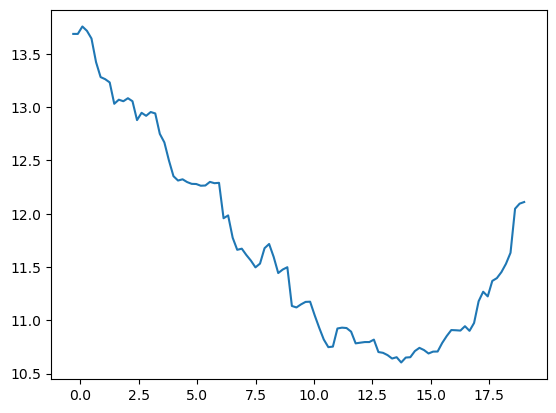

In [10]:
plt.plot(pardep['grid_values'][0],pardep['average'][0])
plt.show()

This is an interesting plot. Based on the range of temperature values captured in our data, we see there are clearly two regimes of increased levels of predicted PM2.5 Because we have trained our model to years of data and used a robust tes-train-validate strategy, we can assume this is represetative of the real data. At low temperatures, there is a sharp increase. Likewise, as temperatures increase, we see levels increasing. These could be related to different emission and atmospheric transformation processes.

As already noted, partial dependency plots do have a number of limitations. It would be good to visualise the distribution of X values used. In the following function we modify an existing solution provided [online]() to generate the same information given above but also show the distribution of X values, thus temperature in this instance. 

Once defined we call this function in the proceeding code block.

In [11]:
def plot_pdp(model, X, feature, target=False, return_pd=False, y_pct=True, figsize=(10,9), norm_hist=True, dec=.5):
    # Get partial dependence
    pardep = partial_dependence(model, X, [feature])

    # Get min & max values
    xmin = pardep['grid_values'][0].min() #pardep[1][0].min()
    xmax = pardep['grid_values'][0].max() #pardep[1][0].max()
    ymin = pardep['average'][0].min() #pardep[0][0].min()
    ymax = pardep['average'][0].max()

    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.grid(alpha=.5, linewidth=1)

    # Plot partial dependence
    color = 'tab:blue'
    ax1.plot(pardep['grid_values'][0],pardep['average'][0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel(feature, fontsize=14)

    tar_ylabel = ': {}'.format(target) if target else ''
    ax1.set_ylabel('Partial Dependence{}'.format(tar_ylabel), color=color, fontsize=14)

    tar_title = target if target else 'Target Variable'
    ax1.set_title('Relationship Between {} and {}'.format(feature, tar_title), fontsize=16)

    if y_pct and ymin>=0 and ymax<=1:
        # Display yticks on ax1 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax1.get_yticklabels()]
        labels = [int(float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax1.set_yticklabels(labels)

    # Plot line for decision boundary
    ax1.hlines(dec, xmin=xmin, xmax=xmax, color='black', linewidth=2, linestyle='--', label='Decision Boundary')
    ax1.legend()

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.hist(X[feature], bins=80, range=(xmin, xmax), alpha=.25, color=color, density=norm_hist)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Distribution', color=color, fontsize=14)

    if y_pct and norm_hist:
        # Display yticks on ax2 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels = [int(float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax2.set_yticklabels(labels)

    plt.show()


C:\Users\mccikdt3\AppData\Local\Temp\ipykernel_28700\4141572254.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(labels)


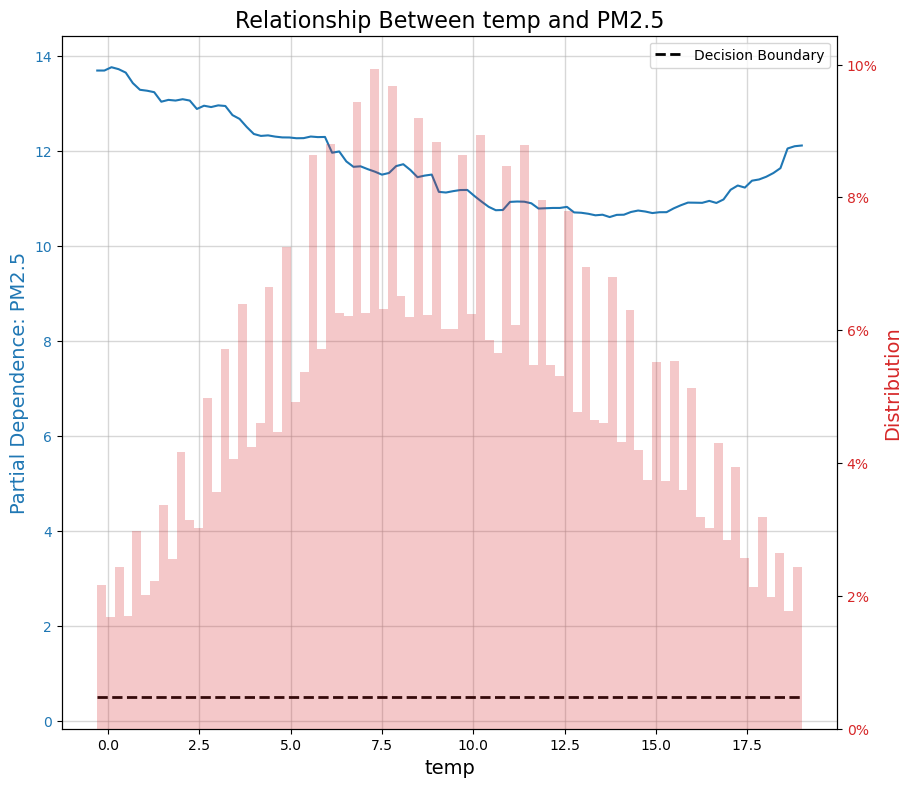

In [12]:
plot_pdp(best_model, features_df, 'temp', target='PM2.5')

<div class="alert alert-block alert-success">
<b> Exercise 1 <a name="Exercise1"></a></b> 

##### Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.
    
Repeat the above function call but for seperate instances of the following meteorological variables:
    
    - Relative humidity
    - Wind speed
    - Boundary layer height
    
You will need to identify the relevant column name from the dataframe for each one. For example, you should derive the following figure when generating a partial deendency of predicted PM2.5 on boundary layer height:
    
<img src="images/pdep_blh.png" alt="PDP with respect to boundary layer height" style="width: 600px;"/>
    

</div>

C:\Users\mccikdt3\AppData\Local\Temp\ipykernel_20384\4141572254.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(labels)


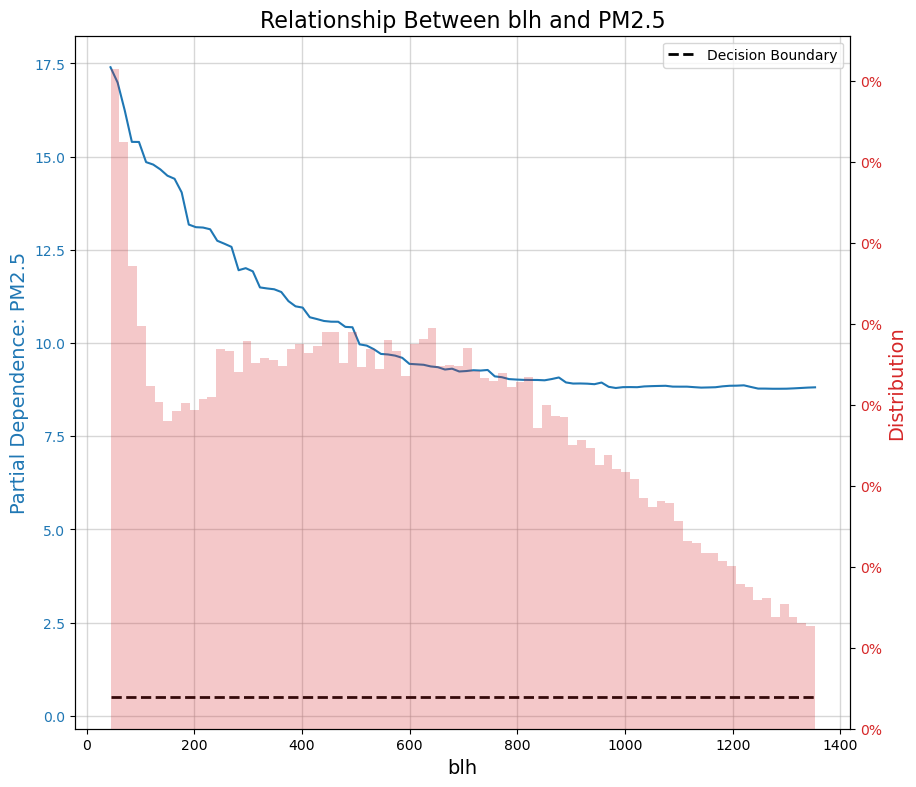

In [16]:
#------INSERT CODE HERE --------
plot_pdp(best_model, features_df, 'blh', target='PM2.5')
#-------------------------------

#### 2.2 SHAP analysis

In the above text we refer to potentially more powerful analytics, including SHAP analysis. We retain the need to answer the question: Can we use the features and parameters of a trained model to understand the underlying relationships? Take the example of linear regression; Whilst the values of the learned coefficients might offer some insight these are not a great method for understanding the importance of a given feature. The scaling of the 'X' variable, for example, will impact on the value of the coefficient. The partial depedency plots above give more insight, but also we note that the distribution of values would affect confidence in areas where data is lacking.

SHAP (SHapley Additive exPlanations) analysis is a method used to explain the output of machine learning models, particularly for complex models such as deep learning and ensemble algorithms. The main goal of SHAP analysis is to provide an understandable and interpretable representation of how the features of an input instance contribute to the model's prediction.

SHAP analysis is based on the concept of Shapley values, which originated from cooperative game theory. Shapley values provide a way to fairly distribute a total value among multiple contributors, based on their individual contributions. Shapley values are a concept originating from cooperative game theory, proposed by Lloyd Shapley in 1953. They provide a method for fairly allocating the gains or costs of a cooperative game among its players, taking into account their individual contributions. The Shapley value has several desirable properties, such as efficiency, symmetry, dummy player property, and additivity.

In the context of machine learning, Shapley values are used to allocate the contribution of each feature to the model's prediction for a specific instance. The main idea is to treat the features as players in a cooperative game, where the "gain" is the difference between the prediction for the instance and the average prediction for the entire dataset.

Here's a more detailed explanation of the Shapley value calculation for a machine learning model:

 - 1. Consider all possible subsets of features, including the empty set and the set with all features. For a model with n features, there are 2^n possible subsets.
 - 2. For each subset, evaluate the model's prediction using only the features in that subset. For features not in the subset, use a reference value, such as the feature's mean or median value from the dataset.
  - 3. Calculate the marginal contribution of each feature by comparing the prediction of a subset that includes the feature with the prediction of the same subset without the feature.
  - 4. Compute the Shapley value for each feature by taking the weighted average of its marginal contributions across all possible subsets. The weight for each subset is given by the formula:
  - Weight = (|S|!(n-|S|-1)!)/(n!)

where |S| is the number of features in subset S, and n is the total number of features.
The Shapley values have some key properties that make them suitable for explaining machine learning models:

 - a) Efficiency: The sum of the Shapley values for all features equals the total gain, which is the difference between the model's prediction for the instance and the average prediction for the entire dataset.
 - b) Symmetry: If two features contribute equally to the model's prediction, they will have the same Shapley value.
 - c) Dummy player property: If a feature has no impact on the prediction, its Shapley value will be zero.
 - d) Additivity: If the gains from two different cooperative games can be combined, the Shapley values of the combined game will be the sum of the Shapley values of the individual games.

By using Shapley values, we can fairly allocate the contributions of each feature to the model's prediction and provide an interpretable explanation for complex machine learning models.

*One of the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.* 


We dont have to implement our own method to calculate Shapley values. We import the <code> shap </code> package to do this for us. We pass our previously fit model to a <code> TreeExplainer </code> function and extract shap values based on a validation dataset as per the code given below.

Notice that we have to create a training and validation split in our dataset again. We pass the validation datset to our SHAP analysis to extract the shapely values


In [13]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(features_df,y_df, test_size=0.2, random_state=10)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(Xv)


We can also use the internal depedency plot of the SHAP package to visualise the dependency on our regressed variable [in this case PM2.5], on any features. In the plot below, we can visualise the joint dependency on temperature and RH. Notice how, in this function call, we pass the value of <code> interaction_index </code>. In this case we set this to 'r', the name of the column that represents relative humidity.

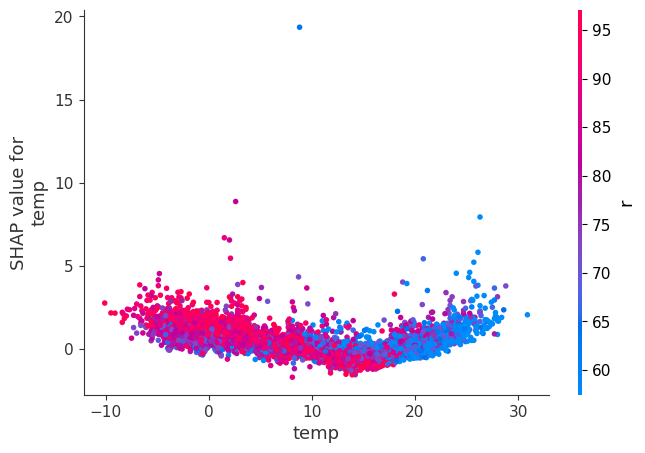

In [14]:
shap.dependence_plot("temp", shap_values, Xv, interaction_index="r")


So we can see here that we still infer that predicted PM2.5 increases at lowest and highest temperatures. But we also see that those higher temperatures correspond to lower relative humidity, whilst the lower temperatures higher humidity. Does this make sense?

As another example, in the following code snippet we visualise the dependency between temperature and month of the year.

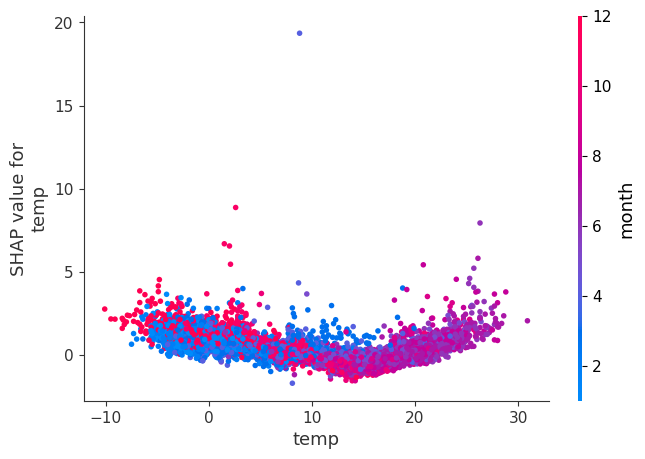

In [15]:
shap.dependence_plot("temp", shap_values, Xv, interaction_index="month")


<div class="alert alert-block alert-success">
<b> Exercise 2 <a name="Exercise2"></a></b> 

##### Generate SHAP analysis for Manchester Piccadilly site.
    
Repeat the above function call but for seperate instances of the following meteorological variables and interactions:
    
    - Relative humidity and day of the year
    - Wind speed and Boundary layer height
    
You will need to identify the relevant column name from the dataframe for each one.
    
</div>

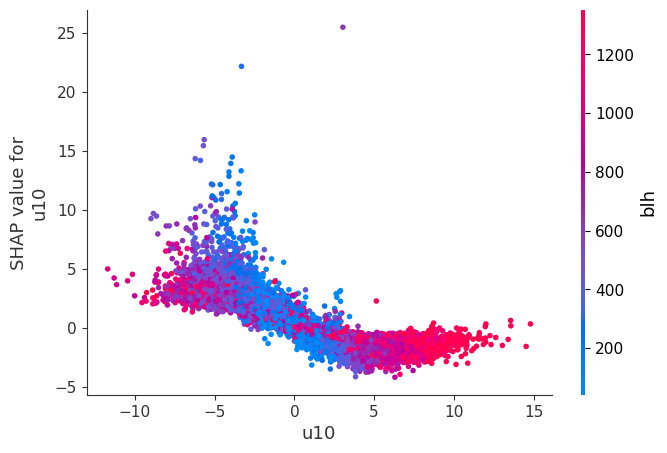

In [28]:
#------INSERT CODE HERE --------
shap.dependence_plot("u10", shap_values, Xv, interaction_index="blh")
#-------------------------------

What if we wanted to compare all variables alongside each other? For this we can use a summary plot. In the summary plot produced below, we can visualise the impact of each feature on the SHAP value as a function of the feature value. Please note that we cannot directly translate the SHAP value to the level of change in PM2.5. This calculation can also take a while to run. 

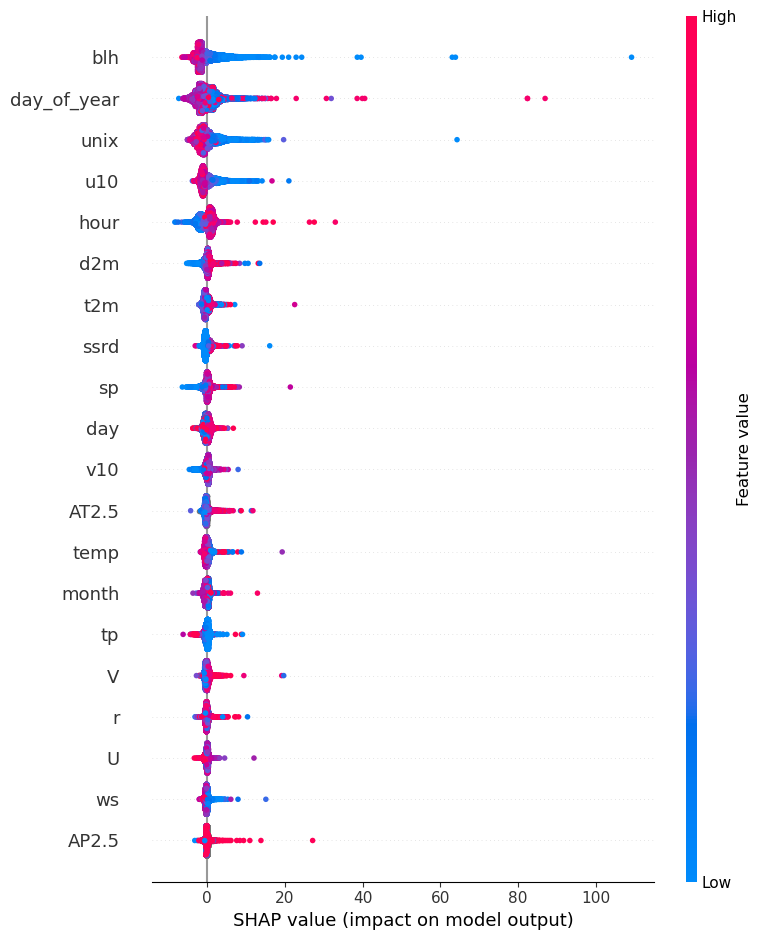

In [16]:
shap.summary_plot(shap_values, Xv)


Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

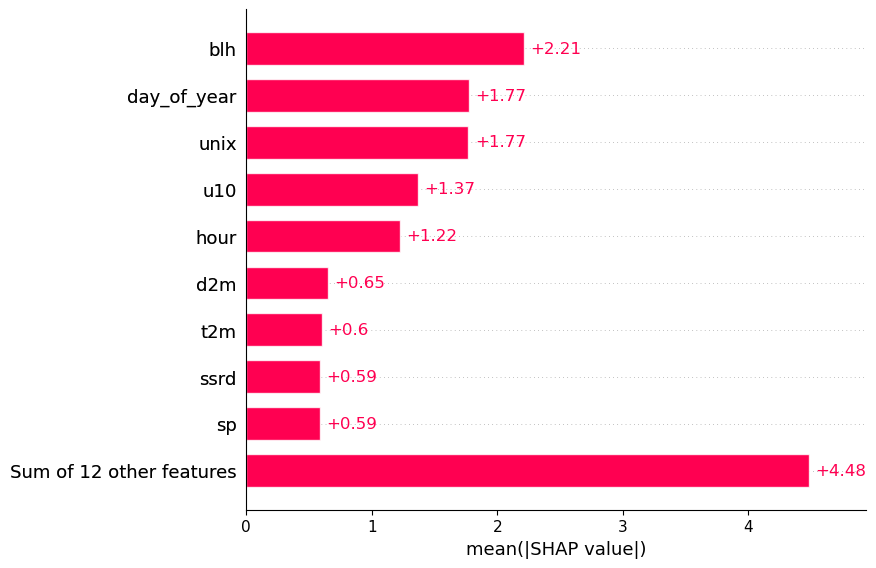

In [18]:
shap_values = explainer(X)
shap_values.feature_names = ['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']
shap.plots.bar(shap_values)

# 3) Using automated machine learning (AutoML) to establish the regression model between concentration and meteorological parameters

AutoML (Automated Machine Learning) is a framework or set of tools designed to automate the process of building and optimizing machine learning models. Instead of manually experimenting with numerous algorithms, hyperparameter values, and preprocessing steps, AutoML systems systematically explore these options on behalf of the user. For scientists, this is particularly beneficial because it lowers the barrier to entry for using ML techniques, saves time by bypassing repetitive tuning tasks, and accelerates model development through rapid experimentation. As a result, researchers can spend more effort focusing on interpreting results and extracting scientific insights, rather than the mechanics of model building.

FLAML (Fast and Lightweight AutoML,https://microsoft.github.io/FLAML/docs/getting-started) is an open-source, lightweight, and efficient automatic machine learning (AutoML) library designed to simplify the machine learning process. Developed by Microsoft, FLAML aims to make AutoML more accessible by providing fast and cost-effective solutions for model training and hyperparameter tuning without compromising accuracy.

Unlike many other AutoML frameworks, FLAML focuses on simplicity and speed by employing lightweight model selection strategies and dynamic resource allocation, which makes it well-suited for large datasets or scenarios with limited computational budgets. Out of the box, FLAML supports several popular model families, including:

 - LightGBM (gradient boosting trees)
 - XGBoost (gradient boosting trees)
 - Random Forest (via scikit-learn)
 - Extra Trees (via scikit-learn)
 - Linear Models (e.g., Lasso, Ridge, ElasticNet via scikit-learn)

By automatically tuning hyperparameters and selecting the best model type for a given task (classification, regression, or even forecasting), FLAML allows users—especially those who may not be machine learning experts—to quickly achieve strong predictive performance without exhaustive manual experimentation.

In the following activities, we will utilize the superior performance of FLAML to build regression models for pollutant concentrations and meteorological parameters using the following steps:

    *prepare the input data for AutoML
    *import the FLAML package (if installed)
    *set the target and parameters for AutoML parameters
        -task type
        -time budget of AutoML
        -optimazation metric
        -estimators used in this task

In [19]:
from flaml import AutoML

# set the parameters for AutoML
automl = AutoML()
automl_settings = {
            "time_budget": 20,
            "metric": 'r2',
            "task": 'regression',
            "estimator_list": ["lgbm", "rf", "xgboost", "extra_tree"],
            'seed': 7654321
        }

In [20]:
# run the AutoML
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 02-11 11:03:15] {1728} INFO - task = regression
[flaml.automl.logger: 02-11 11:03:15] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-11 11:03:15] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 02-11 11:03:15] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree']
[flaml.automl.logger: 02-11 11:03:15] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-11 11:03:16] {2393} INFO - Estimated sufficient time budget=6745s. Estimated necessary time budget=7s.
[flaml.automl.logger: 02-11 11:03:16] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.9148,	best estimator lgbm's best error=0.9148
[flaml.automl.logger: 02-11 11:03:16] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-11 11:03:16] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.9148,	best estimator lgbm's best error=0.9148
[flaml.automl.logger: 02-11 11:03:16] {2258} INFO - iteration 2, c

C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

[flaml.automl.logger: 02-11 11:03:16] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.5412,	best estimator lgbm's best error=0.5412
[flaml.automl.logger: 02-11 11:03:16] {2258} INFO - iteration 4, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 1.3s,	estimator lgbm's best error=0.5412,	best estimator lgbm's best error=0.5412
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 5, current learner xgboost
[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 1.4s,	estimator xgboost's best error=0.9137,	best estimator lgbm's best error=0.5412
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 1.4s,	estimator xgboost's best error=0.9137,	best estimator lgbm's best error=0.5412
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 7, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 1.7s,	estimator lgbm's best error=0.4409,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 8, current learner xgboost
[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 1.8s,	estimator xgboost's best error=0.6821,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 9, current learner extra_tree


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:17] {2442} INFO -  at 2.1s,	estimator extra_tree's best error=0.8646,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:17] {2258} INFO - iteration 10, current learner rf
[flaml.automl.logger: 02-11 11:03:18] {2442} INFO -  at 2.4s,	estimator rf's best error=0.8422,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:18] {2258} INFO - iteration 11, current learner xgboost
[flaml.automl.logger: 02-11 11:03:18] {2442} INFO -  at 2.7s,	estimator xgboost's best error=0.5913,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:18] {2258} INFO - iteration 12, current learner rf
[flaml.automl.logger: 02-11 11:03:18] {2442} INFO -  at 3.0s,	estimator rf's best error=0.8235,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:18] {2258} INFO - iteration 13, current learner extra_tree
[flaml.automl.logger: 02-11 11:03:19] {2442} INFO -  at 3.2s,	estimator extra_tree's best 

C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:19] {2442} INFO -  at 4.1s,	estimator lgbm's best error=0.4409,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:19] {2258} INFO - iteration 17, current learner xgboost
[flaml.automl.logger: 02-11 11:03:20] {2442} INFO -  at 4.3s,	estimator xgboost's best error=0.5913,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:20] {2258} INFO - iteration 18, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:20] {2442} INFO -  at 4.7s,	estimator lgbm's best error=0.4409,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:20] {2258} INFO - iteration 19, current learner xgboost


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:21] {2442} INFO -  at 5.2s,	estimator xgboost's best error=0.5913,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:21] {2258} INFO - iteration 20, current learner lgbm
[flaml.automl.logger: 02-11 11:03:21] {2442} INFO -  at 5.4s,	estimator lgbm's best error=0.4409,	best estimator lgbm's best error=0.4409
[flaml.automl.logger: 02-11 11:03:21] {2258} INFO - iteration 21, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:22] {2442} INFO -  at 6.4s,	estimator lgbm's best error=0.3211,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:22] {2258} INFO - iteration 22, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:22] {2442} INFO -  at 6.8s,	estimator lgbm's best error=0.3211,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:22] {2258} INFO - iteration 23, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:25] {2442} INFO -  at 10.1s,	estimator lgbm's best error=0.3211,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:25] {2258} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 02-11 11:03:26] {2442} INFO -  at 10.3s,	estimator xgboost's best error=0.5913,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:26] {2258} INFO - iteration 25, current learner extra_tree


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:26] {2442} INFO -  at 10.5s,	estimator extra_tree's best error=0.8482,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:26] {2258} INFO - iteration 26, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:26] {2442} INFO -  at 11.0s,	estimator lgbm's best error=0.3211,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:26] {2258} INFO - iteration 27, current learner xgboost


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:27] {2442} INFO -  at 11.6s,	estimator xgboost's best error=0.5525,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:27] {2258} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 02-11 11:03:27] {2442} INFO -  at 12.0s,	estimator xgboost's best error=0.5525,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:27] {2258} INFO - iteration 29, current learner extra_tree
[flaml.automl.logger: 02-11 11:03:28] {2442} INFO -  at 12.2s,	estimator extra_tree's best error=0.7881,	best estimator lgbm's best error=0.3211
[flaml.automl.logger: 02-11 11:03:28] {2258} INFO - iteration 30, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:30] {2442} INFO -  at 15.1s,	estimator lgbm's best error=0.2925,	best estimator lgbm's best error=0.2925
[flaml.automl.logger: 02-11 11:03:30] {2258} INFO - iteration 31, current learner lgbm


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:35] {2442} INFO -  at 19.9s,	estimator lgbm's best error=0.2925,	best estimator lgbm's best error=0.2925


C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mccikdt3\anaconda3\envs\CDTModelling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 02-11 11:03:38] {2685} INFO - retrain lgbm for 3.0s
[flaml.automl.logger: 02-11 11:03:38] {2688} INFO - retrained model: LGBMRegressor(colsample_bytree=np.float64(0.939764657521115),
              learning_rate=np.float64(0.4019047087060252), max_bin=1023,
              min_child_samples=11, n_estimators=89, n_jobs=-1, num_leaves=271,
              reg_alpha=np.float64(0.0012790126343383958),
              reg_lambda=np.float64(0.03939140655959978), verbose=-1)
[flaml.automl.logger: 02-11 11:03:38] {1985} INFO - fit succeeded
[flaml.automl.logger: 02-11 11:03:38] {1986} INFO - Time taken to find the best model: 15.129819631576538


We can also access the best available model arising from the training.

In [21]:
# read the model parameters and details
best_params = automl.best_config
print("Best Model Parameters:", best_params)
best_model_type = automl.best_estimator
print("Best Model Type:", best_model_type)

Best Model Parameters: {'n_estimators': 89, 'num_leaves': 271, 'min_child_samples': 11, 'learning_rate': np.float64(0.4019047087060252), 'log_max_bin': 10, 'colsample_bytree': np.float64(0.939764657521115), 'reg_alpha': np.float64(0.0012790126343383958), 'reg_lambda': np.float64(0.03939140655959978)}
Best Model Type: lgbm


<div class="alert alert-block alert-success">
<b> Exercise 3 <a name="Exercise3"></a></b> 

##### Generate SHAP analysis for Manchester Piccadilly site.
    
Replicate the previous approach for conducting SHAP analysis but using the best model extracted from AutoML
    
</div>

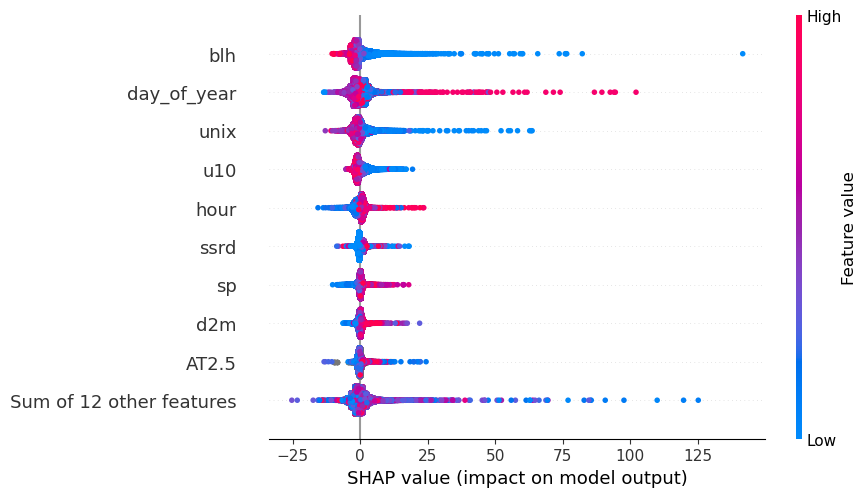

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

In [22]:
#------INSERT CODE HERE --------
# run the SHAP analysis
explainer = shap.Explainer(automl.model.estimator)

shap_values = explainer(X)
shap_values.feature_names = ['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']

plt.figure()
shap.plots.beeswarm(shap_values)
# plt.tight_layout()
plt.gcf().set_size_inches(10,8)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#------INSERT CODE HERE --------
